In [1]:

#Installing all necessary packages 
!pip install snowflake-connector-python[pandas]
!pip install holidays
!pip install --upgrade snowflake-sqlalchemy
!pip install imblearn
!pip install catboost
!pip install probatus
from probatus.feature_elimination import ShapRFECV
!pip install tensorflow
!pip install ipywidgets
!pip install pandas_profiling
!pip install optuna


import optuna
from sklearn.metrics import mean_squared_error
from pandas_profiling import ProfileReport
import snowflake.connector
import numpy as np
import pandas as pd
import datetime as dt
import boto3
import base64
from numpy import dtype, isnan, sqrt
from sqlalchemy import create_engine
from sqlalchemy import pool
from sqlalchemy.dialects import registry
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.asymmetric import rsa
from cryptography.hazmat.primitives.asymmetric import dsa
from cryptography.hazmat.primitives import serialization
from botocore.exceptions import ClientError
from snowflake.connector.pandas_tools import write_pandas, pd_writer
from dateutil.easter import *
from pathlib import Path
from imblearn.over_sampling import SMOTE
import gc
import dask.dataframe as dd
import dask
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier
import catboost
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, log_loss
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC


import seaborn as sns
import shap
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from optuna.samplers import TPESampler
import catboost
import pickle

!jupyter nbextension enable --py widgetsnbextension

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 23.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


2023-02-07 17:53:00.065842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


`import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
You have an incompatible version of 'pyarrow' installed (10.0.1), please install a version that adheres to: 'pyarrow<8.1.0,>=8.0.0; extra == "pandas"'


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [62]:
# loading datasets
df = pd.read_csv('df.csv')  

df.head()

Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,20,21,22,23,24,25,26,34,35,42,43,44,45,46,48,49,50,51,52,54,55,57,59,61,62,63,64,65,66,67,71,72,73,77,78,79,80,81) have mixed types. Specify dtype option on import or set low_memory=False.


,Unnamed: 0,ad_airing_id,ad_title,viewing_start_time_utc,viewing_start_time_local,tv_day,airing_time_start_local,airing_time_end_local,brand_name,industry,...,METRO,OS,OSFAMILY,PROCESSEDTIME,REGION,SITE,SUPPLYVENDOR,SSP_PLACEMENT_ID,USERHOUROFWEEK,VOLUMECONTROLPRIORITY
0,0,1628267884,WellStar Health System People care,2021-08-06 16:38:04,2021-08-06 12:38:04,2021-08-06 00:00:00,2021-08-06 12:38:04,2021-08-06 12:38:32,WellStar Health System,Health,...,524.0,101.0,1.0,2022-11-07 19:56:31.9101,Georgia,sling-production-6.13.2.247-tv,freewheel,NaN,38.0,1.0
1,1,1628267884,WellStar Health System People care,2021-08-06 16:38:04,2021-08-06 12:38:04,2021-08-06 00:00:00,2021-08-06 12:38:04,2021-08-06 12:38:32,WellStar Health System,Health,...,524.0,101.0,1.0,2022-11-07 06:05:11.8246,Georgia,68669,freewheel,NaN,24.0,0.0
2,2,1628267884,WellStar Health System People care,2021-08-06 16:38:04,2021-08-06 12:38:04,2021-08-06 00:00:00,2021-08-06 12:38:04,2021-08-06 12:38:32,WellStar Health System,Health,...,524.0,101.0,1.0,2022-11-07 02:36:56.6353,Georgia,com.fubotv.roku.syfy,Magnite CTV,uszu8-ww6dk,21.0,0.0
3,3,1628267884,WellStar Health System People care,2021-08-06 16:38:04,2021-08-06 12:38:04,2021-08-06 00:00:00,2021-08-06 12:38:04,2021-08-06 12:38:32,WellStar Health System,Health,...,524.0,101.0,1.0,2022-11-07 04:21:37.5219,Georgia,43465,Magnite CTV,uszu8-b9ug0,23.0,0.0
4,4,1628267884,WellStar Health System People care,2021-08-06 16:38:04,2021-08-06 12:38:04,2021-08-06 00:00:00,2021-08-06 12:38:04,2021-08-06 12:38:32,WellStar Health System,Health,...,524.0,179.0,6.0,2022-10-18 21:39:43.3417,Georgia,eyeq,freewheel,NaN,65.0,50.0


In [65]:
# x = list(df.columns)

# colnames = pd.DataFrame(x)
# colnames.to_csv("colnames.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5132163 entries, 0 to 5132162
Data columns (total 84 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Unnamed: 0                   int64  
 1   ad_airing_id                 object 
 2   ad_title                     object 
 3   viewing_start_time_utc       object 
 4   viewing_start_time_local     object 
 5   tv_day                       object 
 6   airing_time_start_local      object 
 7   airing_time_end_local        object 
 8   brand_name                   object 
 9   industry                     object 
 10  sub_industry                 object 
 11  application                  object 
 12  channel_type                 object 
 13  program                      object 
 14  content_id                   float64
 15  hh_id_hashed                 object 
 16  viewer_id_hashed             object 
 17  demo_id_hashed               object 
 18  employment                   object 
 19  

In [66]:
df_new = df[['industry' , "channel_type", "age", 'gender', 'ad_duration', 'active_seconds_in_session', 'attention_seconds', 'daypart_nielsen',
         'brand_parent', 'model', 'zip', 'tvision_manufacturer', 'tvision_os', 'tvision_model', 'tvision_device_type', "ADFORMAT", "DEVICEMODEL", "SUPPLYVENDOR", "USERHOUROFWEEK"]]
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5132163 entries, 0 to 5132162
Data columns (total 19 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   industry                   object 
 1   channel_type               object 
 2   age                        float64
 3   gender                     object 
 4   ad_duration                float64
 5   active_seconds_in_session  float64
 6   attention_seconds          float64
 7   daypart_nielsen            object 
 8   brand_parent               object 
 9   model                      object 
 10  zip                        float64
 11  tvision_manufacturer       object 
 12  tvision_os                 object 
 13  tvision_model              object 
 14  tvision_device_type        object 
 15  ADFORMAT                   object 
 16  DEVICEMODEL                object 
 17  SUPPLYVENDOR               object 
 18  USERHOUROFWEEK             float64
dtypes: float64(6), object(13)
memory usage: 74

In [67]:
#aspect ratio 
null_vals = df_new.isnull().sum().apply(lambda x: x * 100 / df_new.shape[0]).sort_values(ascending = False).loc[lambda x: x > 0]
null_vals

DEVICEMODEL                  30.822209
tvision_device_type          30.648072
tvision_model                30.648072
tvision_os                   30.648072
tvision_manufacturer         30.648072
brand_parent                 30.595833
model                        30.512320
zip                          30.512320
SUPPLYVENDOR                 30.512320
ADFORMAT                     30.512320
USERHOUROFWEEK               30.512320
channel_type                 30.282904
daypart_nielsen              30.282904
attention_seconds            30.282904
active_seconds_in_session    30.282904
ad_duration                  30.282904
gender                       30.282904
age                          30.282904
industry                     30.282904
dtype: float64

In [68]:
df_new = df_new.dropna()


In [69]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3539083 entries, 0 to 5132162
Data columns (total 19 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   industry                   object 
 1   channel_type               object 
 2   age                        float64
 3   gender                     object 
 4   ad_duration                float64
 5   active_seconds_in_session  float64
 6   attention_seconds          float64
 7   daypart_nielsen            object 
 8   brand_parent               object 
 9   model                      object 
 10  zip                        float64
 11  tvision_manufacturer       object 
 12  tvision_os                 object 
 13  tvision_model              object 
 14  tvision_device_type        object 
 15  ADFORMAT                   object 
 16  DEVICEMODEL                object 
 17  SUPPLYVENDOR               object 
 18  USERHOUROFWEEK             float64
dtypes: float64(6), object(13)
memory usage: 54

In [70]:
df_new['age'] = pd.to_numeric(df_new['age'], errors='coerce')
df_new['age'] = df_new['age'].astype('Int64')
df_new['ad_duration'] = df_new['ad_duration'].astype('Int64')

df_new['ad_duration'] = pd.to_numeric(df_new['ad_duration'], errors='coerce')
df_new

,industry,channel_type,age,gender,ad_duration,active_seconds_in_session,attention_seconds,daypart_nielsen,brand_parent,model,zip,tvision_manufacturer,tvision_os,tvision_model,tvision_device_type,ADFORMAT,DEVICEMODEL,SUPPLYVENDOR,USERHOUROFWEEK
0,Health,CTV,30,F,29,8399.0,0.0,Daytime,Wellstar Health System,65R6+,30135.0,Hisense,Roku,65R6+,Smart TV,640x360,Digital Video player,freewheel,38.0
1,Health,CTV,30,F,29,8399.0,0.0,Daytime,Wellstar Health System,65R6+,30135.0,Hisense,Roku,65R6+,Smart TV,640x360,Digital Video player,freewheel,24.0
2,Health,CTV,30,F,29,8399.0,0.0,Daytime,Wellstar Health System,65R6+,30135.0,Hisense,Roku,65R6+,Smart TV,640x360,Digital Video player,Magnite CTV,21.0
3,Health,CTV,30,F,29,8399.0,0.0,Daytime,Wellstar Health System,65R6+,30135.0,Hisense,Roku,65R6+,Smart TV,640x360,Digital Video player,Magnite CTV,23.0
4,Health,CTV,30,F,29,8399.0,0.0,Daytime,Wellstar Health System,65R6+,30135.0,Hisense,Roku,65R6+,Smart TV,640x360,SM-A716U,freewheel,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5132158,Legal / Financial,CTV,65,F,18,1111.0,0.0,Early Morning,Progressive Corp,Roku Premiere,77045.0,Roku,Roku,Roku,Streaming Device,640x360,iPhone,themediagrid,79.0
5132159,Legal / Financial,CTV,65,F,18,1111.0,0.0,Early Morning,Progressive Corp,Roku Premiere,77045.0,Roku,Roku,Roku,Streaming Device,640x360,Safari - OS X,themediagrid,77.0
5132160,Legal / Financial,CTV,65,F,18,1111.0,0.0,Early Morning,Progressive Corp,Roku Premiere,77045.0,Roku,Roku,Roku,Streaming Device,640x360,Safari - OS X,themediagrid,77.0
5132161,Legal / Financial,CTV,65,F,18,1111.0,0.0,Early Morning,Progressive Corp,Roku Premiere,77045.0,Roku,Roku,Roku,Streaming Device,640x360,SM-G975U,freewheel,49.0


In [71]:

bins = [0,18,25,50,100]
labels=[0,1,2,3]
df_new['bins_age'] = pd.cut(df_new['age'], bins=bins, labels=labels, include_lowest=True)


In [72]:

bins = [0,15,103]
labels=[0,1]
df_new['bins_adduration'] = pd.cut(df_new['ad_duration'], bins=bins, labels=labels, include_lowest=True)


In [73]:
df_new['bins_age'].value_counts()*100/df_new.shape[0]


2    46.081994
3    45.071478
0     8.243520
1     0.603009
Name: bins_age, dtype: float64

In [74]:

df_new['attention_seconds'] = pd.to_numeric(df_new['attention_seconds'], errors='coerce')

df_new['attention_seconds'].value_counts()*100/df_new.shape[0]


0.0      56.287745
14.0      4.236945
1.0       4.006857
2.0       2.879814
3.0       2.376520
           ...    
79.0      0.000141
101.0     0.000028
103.0     0.000028
108.0     0.000028
94.0      0.000028
Name: attention_seconds, Length: 115, dtype: float64

In [75]:
df_new

,industry,channel_type,age,gender,ad_duration,active_seconds_in_session,attention_seconds,daypart_nielsen,brand_parent,model,...,tvision_manufacturer,tvision_os,tvision_model,tvision_device_type,ADFORMAT,DEVICEMODEL,SUPPLYVENDOR,USERHOUROFWEEK,bins_age,bins_adduration
0,Health,CTV,30,F,29,8399.0,0.0,Daytime,Wellstar Health System,65R6+,...,Hisense,Roku,65R6+,Smart TV,640x360,Digital Video player,freewheel,38.0,2,1
1,Health,CTV,30,F,29,8399.0,0.0,Daytime,Wellstar Health System,65R6+,...,Hisense,Roku,65R6+,Smart TV,640x360,Digital Video player,freewheel,24.0,2,1
2,Health,CTV,30,F,29,8399.0,0.0,Daytime,Wellstar Health System,65R6+,...,Hisense,Roku,65R6+,Smart TV,640x360,Digital Video player,Magnite CTV,21.0,2,1
3,Health,CTV,30,F,29,8399.0,0.0,Daytime,Wellstar Health System,65R6+,...,Hisense,Roku,65R6+,Smart TV,640x360,Digital Video player,Magnite CTV,23.0,2,1
4,Health,CTV,30,F,29,8399.0,0.0,Daytime,Wellstar Health System,65R6+,...,Hisense,Roku,65R6+,Smart TV,640x360,SM-A716U,freewheel,65.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5132158,Legal / Financial,CTV,65,F,18,1111.0,0.0,Early Morning,Progressive Corp,Roku Premiere,...,Roku,Roku,Roku,Streaming Device,640x360,iPhone,themediagrid,79.0,3,1
5132159,Legal / Financial,CTV,65,F,18,1111.0,0.0,Early Morning,Progressive Corp,Roku Premiere,...,Roku,Roku,Roku,Streaming Device,640x360,Safari - OS X,themediagrid,77.0,3,1
5132160,Legal / Financial,CTV,65,F,18,1111.0,0.0,Early Morning,Progressive Corp,Roku Premiere,...,Roku,Roku,Roku,Streaming Device,640x360,Safari - OS X,themediagrid,77.0,3,1
5132161,Legal / Financial,CTV,65,F,18,1111.0,0.0,Early Morning,Progressive Corp,Roku Premiere,...,Roku,Roku,Roku,Streaming Device,640x360,SM-G975U,freewheel,49.0,3,1


In [76]:
df1 = pd.DataFrame(df_new['brand_parent'].value_counts()*100/df_new.shape[0])
df1 = df1.reset_index()
df1 = df1.rename(columns={'brand_parent': 'weight', 'index': 'brand_parent'})
df1



,brand_parent,weight
0,Procter & Gamble Co,3.930142
1,Comcast Corp,3.307721
2,Walt Disney Co,2.830479
3,PARENT UNKNOWN,1.830841
4,Berkshire Hathaway Inc,1.429608
...,...,...
3609,Florida Leather Gallery,0.000028
3610,Mollie Biggane Melanoma Foundation,0.000028
3611,Ora Dental Implant Studio,0.000028
3612,Sacramento-Yolo Mosquito & Vector Control Dist...,0.000028


In [77]:
df_new = df_new.merge(df1, how='left', on='brand_parent')

In [78]:

df_new['attention_seconds_weight'] = df_new['attention_seconds']*df_new['weight']

df_new['attention_seconds_weight'].value_counts()*100/df_new.shape[0]


0.000000     56.287745
55.021993     0.225595
3.930142      0.167247
46.308097     0.141138
3.307721      0.132012
               ...    
0.465403      0.000028
0.560484      0.000028
0.866298      0.000028
0.458735      0.000028
0.469048      0.000028
Name: attention_seconds_weight, Length: 17726, dtype: float64

In [79]:
df_new['attention_seconds_weight'].agg(['min', 'max'])



min      0.000000
max    232.099275
Name: attention_seconds_weight, dtype: float64

In [80]:



bins = [0,0.5, 5,55, 233]
labels=[0,1,2,3]
df_new['bins_attention_seconds'] = pd.cut(df_new['attention_seconds_weight'], bins=bins, labels=labels, include_lowest=True)
df_new['bins_attention_seconds'].value_counts()*100/df_new.shape[0]





0    72.003793
1    13.371741
2    13.364705
3     1.259761
Name: bins_attention_seconds, dtype: float64

In [81]:
df_new['zip'] = pd.to_numeric(df_new['zip'], errors='coerce')


In [82]:
df_new = df_new.dropna()
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3536361 entries, 0 to 3539082
Data columns (total 24 columns):
 #   Column                     Dtype   
---  ------                     -----   
 0   industry                   object  
 1   channel_type               object  
 2   age                        Int64   
 3   gender                     object  
 4   ad_duration                Int64   
 5   active_seconds_in_session  float64 
 6   attention_seconds          float64 
 7   daypart_nielsen            object  
 8   brand_parent               object  
 9   model                      object  
 10  zip                        float64 
 11  tvision_manufacturer       object  
 12  tvision_os                 object  
 13  tvision_model              object  
 14  tvision_device_type        object  
 15  ADFORMAT                   object  
 16  DEVICEMODEL                object  
 17  SUPPLYVENDOR               object  
 18  USERHOUROFWEEK             float64 
 19  bins_age             

In [83]:
df2 = pd.read_csv('zipmap.csv')
df2

,Geosegmentid,ZipCode
0,aqjrxyckhf,36753
1,p8v9tr4ulz,53920
2,kiwg58ilg6,37815
3,c8cs7wy3az,54874
4,8daj4qbp5m,37831
...,...,...
38141,6z2gx81x8t,96158
38142,rw95aymvcq,68742
38143,5nzfh8yxbl,11703
38144,2xuahvz5qp,84307


In [84]:
df2 = df2.rename(columns={'Geosegmentid': 'Geosegmentid', 'ZipCode': 'zip'})
df2

df_new = df_new.merge(df2, how='left', on='zip')


In [85]:
df_new

,industry,channel_type,age,gender,ad_duration,active_seconds_in_session,attention_seconds,daypart_nielsen,brand_parent,model,...,ADFORMAT,DEVICEMODEL,SUPPLYVENDOR,USERHOUROFWEEK,bins_age,bins_adduration,weight,attention_seconds_weight,bins_attention_seconds,Geosegmentid
0,Health,CTV,30,F,29,8399.0,0.0,Daytime,Wellstar Health System,65R6+,...,640x360,Digital Video player,freewheel,38.0,2,1,0.029838,0.0,0,4jsd435rp6
1,Health,CTV,30,F,29,8399.0,0.0,Daytime,Wellstar Health System,65R6+,...,640x360,Digital Video player,freewheel,24.0,2,1,0.029838,0.0,0,4jsd435rp6
2,Health,CTV,30,F,29,8399.0,0.0,Daytime,Wellstar Health System,65R6+,...,640x360,Digital Video player,Magnite CTV,21.0,2,1,0.029838,0.0,0,4jsd435rp6
3,Health,CTV,30,F,29,8399.0,0.0,Daytime,Wellstar Health System,65R6+,...,640x360,Digital Video player,Magnite CTV,23.0,2,1,0.029838,0.0,0,4jsd435rp6
4,Health,CTV,30,F,29,8399.0,0.0,Daytime,Wellstar Health System,65R6+,...,640x360,SM-A716U,freewheel,65.0,2,1,0.029838,0.0,0,4jsd435rp6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3536356,Legal / Financial,CTV,65,F,18,1111.0,0.0,Early Morning,Progressive Corp,Roku Premiere,...,640x360,iPhone,themediagrid,79.0,3,1,1.157447,0.0,0,iyagln6ice
3536357,Legal / Financial,CTV,65,F,18,1111.0,0.0,Early Morning,Progressive Corp,Roku Premiere,...,640x360,Safari - OS X,themediagrid,77.0,3,1,1.157447,0.0,0,iyagln6ice
3536358,Legal / Financial,CTV,65,F,18,1111.0,0.0,Early Morning,Progressive Corp,Roku Premiere,...,640x360,Safari - OS X,themediagrid,77.0,3,1,1.157447,0.0,0,iyagln6ice
3536359,Legal / Financial,CTV,65,F,18,1111.0,0.0,Early Morning,Progressive Corp,Roku Premiere,...,640x360,SM-G975U,freewheel,49.0,3,1,1.157447,0.0,0,iyagln6ice


In [86]:
df_new = df_new.sample(frac=0.5)



In [87]:

df_new

,industry,channel_type,age,gender,ad_duration,active_seconds_in_session,attention_seconds,daypart_nielsen,brand_parent,model,...,ADFORMAT,DEVICEMODEL,SUPPLYVENDOR,USERHOUROFWEEK,bins_age,bins_adduration,weight,attention_seconds_weight,bins_attention_seconds,Geosegmentid
854795,Electronics / Technology,CTV,60,F,14,9194.0,12.0,Prime,Canva,Roku Stick,...,640x360,Chrome - Windows,themediagrid,38.0,3,0,0.079738,0.956858,0,3g8ef9hitz
1216749,Health,CTV,31,F,14,11383.0,9.0,Prime,Carlyle Group Lp,Roku Streaming Stick+,...,640x360,iPad,freewheel,66.0,2,0,0.064565,0.581083,0,y7wo7nwo4x
291450,Food / Beverages,CTV,44,F,14,5528.0,14.0,Late Fringe,Kraft Heinz Co,32S331,...,640x360,ANE-LX1,themediagrid,162.0,2,0,0.392503,5.495039,2,v6xjyfu13i
2845748,Restaurants,CTV,43,M,14,14609.0,14.0,Prime Access,Yum Brands Inc,65R617,...,640x360,Digital Video player,spotx,165.0,2,0,0.766074,10.725038,2,yh982ezfhi
1671478,Entertainment / Media / Leisure,CTV,73,F,17,8061.0,17.0,Prime,CBS Corp,Roku Express,...,640x360,SM-A326U,themediagrid,128.0,3,1,0.894639,15.208855,2,psa39ri6ia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269778,Retail,CTV,18,F,29,395.0,0.0,Early Access,The RealReal,Roku Stick,...,640x360,Edge - Windows,themediagrid,153.0,0,1,0.081349,0.000000,0,w8quehwel3
297251,Retail,CTV,44,F,14,9508.0,0.0,Daytime,Gap Inc,49S405,...,640x360,SM-A326U,freewheel,49.0,2,0,0.526662,0.000000,0,v6xjyfu13i
52621,Legal / Financial,CTV,30,F,10,11593.0,0.0,Early Morning,PNC Financial Services Group Inc,65R6+,...,640x360,iPad,freewheel,143.0,2,0,0.129836,0.000000,0,4jsd435rp6
1510833,Automotive / Vehicles,CTV,31,F,6,26091.0,0.0,Early Access,Ford Motor Co,50S421,...,640x360,Chrome - Windows,themediagrid,77.0,2,0,0.396007,0.000000,0,h5xpjfv4py


In [88]:
X = df_new.drop(['bins_attention_seconds', 'bins_adduration', \
        'ad_duration', 'active_seconds_in_session', 'attention_seconds', "tvision_os", 'age', 'channel_type', 'tvision_manufacturer', \
            'tvision_model', 'gender', 'brand_parent', 'industry', 'weight', 'attention_seconds_weight', 'bins_age', \
            'tvision_device_type', "daypart_nielsen", "DEVICEMODEL", "SUPPLYVENDOR", "ADFORMAT"], axis=1)
Y = df_new['bins_attention_seconds']


In [89]:
X

,model,zip,USERHOUROFWEEK,Geosegmentid
854795,Roku Stick,75038.0,38.0,3g8ef9hitz
1216749,Roku Streaming Stick+,92646.0,66.0,y7wo7nwo4x
291450,32S331,19111.0,162.0,v6xjyfu13i
2845748,65R617,85015.0,165.0,yh982ezfhi
1671478,Roku Express,28215.0,128.0,psa39ri6ia
...,...,...,...,...
1269778,Roku Stick,33881.0,153.0,w8quehwel3
297251,49S405,19111.0,49.0,v6xjyfu13i
52621,65R6+,30135.0,143.0,4jsd435rp6
1510833,50S421,77396.0,77.0,h5xpjfv4py


In [90]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1768180 entries, 854795 to 717233
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   model           object 
 1   zip             float64
 2   USERHOUROFWEEK  float64
 3   Geosegmentid    object 
dtypes: float64(2), object(2)
memory usage: 67.5+ MB


In [91]:

# X['zip'] = X['zip'].astype('Int64')
# X['USERHOUROFWEEK'] = X['USERHOUROFWEEK'].astype('Int64')
# X['model'] = X['model'].astype('category')
# X['ADFORMAT'] = X['ADFORMAT'].astype('category')
# X['DEVICEMODEL'] = X['DEVICEMODEL'].astype('category')
# X['SUPPLYVENDOR'] = X['SUPPLYVENDOR'].astype('category')
# X['Geosegmentid'] = X['Geosegmentid'].astype('category')

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1768180 entries, 854795 to 717233
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   model           object 
 1   zip             float64
 2   USERHOUROFWEEK  float64
 3   Geosegmentid    object 
dtypes: float64(2), object(2)
memory usage: 67.5+ MB


In [92]:
Xdata_train, Xdata_val, Ydata_train, Ydata_val = train_test_split(X, Y, test_size=0.3, random_state=0)

categorical_features_indices = np.where(X.dtypes != np.float64)[0]
print(categorical_features_indices)

[0 3]


In [31]:

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTENC


# #Instantiate SMOTENC algorith with 60% oversampling
#sm = SMOTENC(categorical_features=categorical_features_indices, random_state=123, sampling_strategy='auto')

#X_ROS, Y_ROS = sm.fit_resample(X, Y)
#smt = SMOTE(random_state=777, categorical_features=categorical_features_indices)
#rus = RandomUnderSampler(random_state=777)
ros = RandomOverSampler(random_state=777)
X_ROS, Y_ROS = ros.fit_resample(X, Y)


In [32]:
Y_ROS.value_counts()*100/df.shape[0]


0    24.815268
1    24.815268
2    24.815268
3    24.815268
4    24.815268
5    24.815268
6    24.815268
Name: bins_attention_seconds, dtype: float64

In [33]:
Xdata_train, Xdata_val, Ydata_train, Ydata_val = train_test_split(X_ROS, Y_ROS, test_size=0.3, random_state=0)

categorical_features_indices = np.where(X.dtypes != np.float)[0]
print(categorical_features_indices)

[0 3]


`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [37]:
# Xdata_train, Xdata_val, Ydata_train, Ydata_val = train_test_split(X_ROS, Y_ROS, test_size=0.3, random_state=0)

# categorical_features_indices = np.where(X.dtypes != np.float)[0]
# print(categorical_features_indices)

In [ ]:

model = catboost.CatBoostClassifier(verbose=False)
model.fit(Xdata_train, Ydata_train, cat_features=categorical_features_indices)

In [ ]:
y_pred = model.predict(Xdata_val)


In [ ]:
print(classification_report(Ydata_val, y_pred))


NameError: name 'run' is not defined

In [96]:
def objective(trial):
    model = catboost.CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 200),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        loss_function='MultiClass',
        eval_metric='AUC',
        nan_mode='Min',
        thread_count=5,
        task_type='CPU',
        custom_metric=['Accuracy', 'F1', 'Precision', 'Recall'],
        class_weights = [0.8, 0.2,0.2, 0.1],
        verbose=True
    )
    model.fit(Xdata_train, Ydata_train,eval_set=(Xdata_val, Ydata_val),
                              cat_features=categorical_features_indices,
                              verbose_eval=50,
                              early_stopping_rounds=30,
                              use_best_model=True,
                              plot=True)
    y_pred = model.predict(Xdata_val)
    return accuracy_score(Ydata_val, y_pred)

In [97]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=20)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5353590	best: 0.5353590 (0)	total: 551ms	remaining: 1m 17s
50:	test: 0.5581898	best: 0.5581898 (50)	total: 23.2s	remaining: 41.3s
100:	test: 0.5615610	best: 0.5615610 (100)	total: 45.6s	remaining: 18.5s
141:	test: 0.5841612	best: 0.5841612 (141)	total: 1m 3s	remaining: 0us

bestTest = 0.5841611866
bestIteration = 141



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5247107	best: 0.5247107 (0)	total: 787ms	remaining: 2m
50:	test: 0.5522557	best: 0.5523585 (49)	total: 36s	remaining: 1m 12s
100:	test: 0.5553774	best: 0.5556973 (94)	total: 1m 10s	remaining: 37.2s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.555990771
bestIteration = 108

Shrink model to first 109 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5390609	best: 0.5390609 (0)	total: 892ms	remaining: 1m 40s
50:	test: 0.5608456	best: 0.5610817 (46)	total: 44s	remaining: 54.3s
100:	test: 0.5618081	best: 0.5618397 (83)	total: 1m 26s	remaining: 11.2s
113:	test: 0.5617442	best: 0.5618568 (101)	total: 1m 37s	remaining: 0us

bestTest = 0.561856845
bestIteration = 101

Shrink model to first 102 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5325343	best: 0.5325343 (0)	total: 1.17s	remaining: 1m 58s
50:	test: 0.5575195	best: 0.5582556 (27)	total: 55.4s	remaining: 56.5s
100:	test: 0.5608367	best: 0.5608403 (99)	total: 1m 49s	remaining: 2.17s
102:	test: 0.5610031	best: 0.5610031 (102)	total: 1m 51s	remaining: 0us

bestTest = 0.5610031477
bestIteration = 102



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5204417	best: 0.5204417 (0)	total: 560ms	remaining: 1m 34s
50:	test: 0.5659281	best: 0.5659281 (50)	total: 23.2s	remaining: 53.7s
100:	test: 0.5927404	best: 0.5927404 (100)	total: 45.7s	remaining: 30.8s
150:	test: 0.6190938	best: 0.6190938 (150)	total: 1m 8s	remaining: 8.14s
168:	test: 0.6229151	best: 0.6229151 (168)	total: 1m 16s	remaining: 0us

bestTest = 0.622915143
bestIteration = 168



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5407586	best: 0.5407586 (0)	total: 661ms	remaining: 1m 35s
50:	test: 0.5814097	best: 0.5814097 (50)	total: 28.5s	remaining: 52.6s
100:	test: 0.6257719	best: 0.6257719 (100)	total: 55.6s	remaining: 24.2s
144:	test: 0.6394858	best: 0.6394858 (144)	total: 1m 20s	remaining: 0us

bestTest = 0.6394857759
bestIteration = 144



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5389134	best: 0.5389134 (0)	total: 805ms	remaining: 1m 59s
50:	test: 0.5562368	best: 0.5566839 (40)	total: 37s	remaining: 1m 11s
100:	test: 0.5578849	best: 0.5586056 (88)	total: 1m 13s	remaining: 34.7s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5586056351
bestIteration = 88

Shrink model to first 89 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5276749	best: 0.5276749 (0)	total: 680ms	remaining: 1m 35s
50:	test: 0.5537636	best: 0.5537636 (50)	total: 32s	remaining: 56.5s
100:	test: 0.5547601	best: 0.5565588 (76)	total: 1m 3s	remaining: 25s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5565588261
bestIteration = 76

Shrink model to first 77 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5207924	best: 0.5207924 (0)	total: 622ms	remaining: 1m 10s
50:	test: 0.5607191	best: 0.5607191 (50)	total: 28.2s	remaining: 34.8s
100:	test: 0.5965895	best: 0.5965895 (100)	total: 55.8s	remaining: 7.18s
113:	test: 0.6048532	best: 0.6048532 (113)	total: 1m 2s	remaining: 0us

bestTest = 0.6048532282
bestIteration = 113



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5343414	best: 0.5343414 (0)	total: 584ms	remaining: 1m 33s
50:	test: 0.5617230	best: 0.5617295 (49)	total: 28.4s	remaining: 1m 1s
100:	test: 0.5760495	best: 0.5760495 (100)	total: 56.4s	remaining: 34.1s
150:	test: 0.6013613	best: 0.6013613 (150)	total: 1m 23s	remaining: 6.1s
161:	test: 0.6100957	best: 0.6100957 (161)	total: 1m 29s	remaining: 0us

bestTest = 0.6100957268
bestIteration = 161



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5346207	best: 0.5346207 (0)	total: 597ms	remaining: 1m 57s
50:	test: 0.5888003	best: 0.5888003 (50)	total: 25.6s	remaining: 1m 13s
100:	test: 0.6249255	best: 0.6249255 (100)	total: 50.6s	remaining: 48.6s
150:	test: 0.6325249	best: 0.6325249 (150)	total: 1m 15s	remaining: 23.6s
197:	test: 0.6355998	best: 0.6356048 (193)	total: 1m 39s	remaining: 0us

bestTest = 0.6356048362
bestIteration = 193

Shrink model to first 194 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5346207	best: 0.5346207 (0)	total: 589ms	remaining: 1m 51s
50:	test: 0.6044521	best: 0.6044521 (50)	total: 25.7s	remaining: 1m 10s
100:	test: 0.6319551	best: 0.6319551 (100)	total: 50.7s	remaining: 44.6s
150:	test: 0.6365530	best: 0.6365530 (150)	total: 1m 15s	remaining: 19.6s
189:	test: 0.6378571	best: 0.6378666 (187)	total: 1m 35s	remaining: 0us

bestTest = 0.6378666264
bestIteration = 187

Shrink model to first 188 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5346207	best: 0.5346207 (0)	total: 587ms	remaining: 1m 55s
50:	test: 0.5973969	best: 0.5973969 (50)	total: 25.6s	remaining: 1m 13s
100:	test: 0.6314852	best: 0.6314852 (100)	total: 50.4s	remaining: 48.4s
150:	test: 0.6358621	best: 0.6358621 (150)	total: 1m 15s	remaining: 23.6s
197:	test: 0.6374334	best: 0.6374437 (192)	total: 1m 39s	remaining: 0us

bestTest = 0.6374436776
bestIteration = 192

Shrink model to first 193 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5346207	best: 0.5346207 (0)	total: 591ms	remaining: 1m 55s
50:	test: 0.5881386	best: 0.5881386 (50)	total: 25.6s	remaining: 1m 13s
100:	test: 0.6305589	best: 0.6305589 (100)	total: 50.5s	remaining: 48s
150:	test: 0.6365655	best: 0.6365655 (150)	total: 1m 15s	remaining: 23.1s
196:	test: 0.6382209	best: 0.6382209 (196)	total: 1m 38s	remaining: 0us

bestTest = 0.6382209374
bestIteration = 196



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5346207	best: 0.5346207 (0)	total: 571ms	remaining: 1m 43s
50:	test: 0.5596072	best: 0.5600110 (48)	total: 25.6s	remaining: 1m 5s
100:	test: 0.5639777	best: 0.5640072 (99)	total: 50.9s	remaining: 40.8s
150:	test: 0.5662966	best: 0.5670480 (147)	total: 1m 15s	remaining: 15.6s
181:	test: 0.5764790	best: 0.5764790 (181)	total: 1m 31s	remaining: 0us

bestTest = 0.576478996
bestIteration = 181



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5353590	best: 0.5353590 (0)	total: 495ms	remaining: 1m 29s
50:	test: 0.5868392	best: 0.5868392 (50)	total: 22.9s	remaining: 58.9s
100:	test: 0.6194230	best: 0.6194230 (100)	total: 45.6s	remaining: 36.6s
150:	test: 0.6252908	best: 0.6253020 (148)	total: 1m 8s	remaining: 14s
181:	test: 0.6262148	best: 0.6262148 (181)	total: 1m 22s	remaining: 0us

bestTest = 0.6262148056
bestIteration = 181



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5374637	best: 0.5374637 (0)	total: 654ms	remaining: 2m
50:	test: 0.5730845	best: 0.5730845 (50)	total: 32.2s	remaining: 1m 24s
100:	test: 0.6197195	best: 0.6197195 (100)	total: 1m 3s	remaining: 52.7s
150:	test: 0.6323896	best: 0.6323896 (150)	total: 1m 34s	remaining: 21.3s
184:	test: 0.6355191	best: 0.6355191 (184)	total: 1m 56s	remaining: 0us

bestTest = 0.6355190912
bestIteration = 184



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5346207	best: 0.5346207 (0)	total: 536ms	remaining: 1m 30s
50:	test: 0.5542745	best: 0.5545557 (49)	total: 25.4s	remaining: 59.3s
100:	test: 0.5616756	best: 0.5616756 (100)	total: 50.5s	remaining: 34.5s
150:	test: 0.5624215	best: 0.5625846 (138)	total: 1m 15s	remaining: 9.5s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5625846274
bestIteration = 138

Shrink model to first 139 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5407362	best: 0.5407362 (0)	total: 966ms	remaining: 3m 12s
50:	test: 0.5704734	best: 0.5704734 (50)	total: 46.3s	remaining: 2m 15s
100:	test: 0.6067039	best: 0.6067039 (100)	total: 1m 20s	remaining: 1m 18s
150:	test: 0.6330922	best: 0.6330922 (150)	total: 1m 52s	remaining: 36.6s
199:	test: 0.6374464	best: 0.6374800 (194)	total: 2m 26s	remaining: 0us

bestTest = 0.6374799935
bestIteration = 194

Shrink model to first 195 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5353590	best: 0.5353590 (0)	total: 556ms	remaining: 1m 43s
50:	test: 0.5580542	best: 0.5580542 (50)	total: 23.1s	remaining: 1m 2s
100:	test: 0.5615979	best: 0.5619995 (91)	total: 45.8s	remaining: 39.5s
150:	test: 0.5770706	best: 0.5770706 (150)	total: 1m 8s	remaining: 16.8s
187:	test: 0.5894737	best: 0.5894737 (187)	total: 1m 24s	remaining: 0us

bestTest = 0.589473717
bestIteration = 187



In [98]:


print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  20
Best trial:
  Value:  0.7210691219219763
  Params: 
    iterations: 190
    learning_rate: 0.09732156277902732
    depth: 5
    l2_leaf_reg: 0.00017508736881037196
    bootstrap_type: Bayesian
    random_strength: 4.7880968717464415e-08
    bagging_temperature: 2.0064539840920013
    od_type: IncToDec
    od_wait: 22


In [116]:


model = catboost.CatBoostClassifier(**trial.params, 
                            #loss_function='MultiClass',
#                                eval_metric='TotalF1',
#                                nan_mode='Min',
#                                thread_count=8,
#                                task_type='CPU',
#                                custom_metric=['Accuracy', 'F1', 'Precision', 'Recall'],
                              # per_float_feature_quantization='1:border_count=1024',
#                              class_weights =  [0.8, 0.2,0.2, 0.1],
                               verbose=True)
model.fit(Xdata_train, Ydata_train,eval_set=(Xdata_val, Ydata_val),
                              cat_features=categorical_features_indices,
                              verbose_eval=50,
                              early_stopping_rounds=40,
                              use_best_model=True,
                              plot=True)
y_pred = model.predict(Xdata_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.2717203	test: 1.2715136	best: 1.2715136 (0)	total: 209ms	remaining: 39.6s
50:	learn: 0.7928309	test: 0.7908409	best: 0.7908409 (50)	total: 7.95s	remaining: 21.7s
100:	learn: 0.7908204	test: 0.7888328	best: 0.7888328 (100)	total: 15.4s	remaining: 13.6s
150:	learn: 0.7902607	test: 0.7884117	best: 0.7884117 (150)	total: 22.9s	remaining: 5.91s
189:	learn: 0.7899600	test: 0.7882233	best: 0.7882233 (189)	total: 28.7s	remaining: 0us

bestTest = 0.7882232719
bestIteration = 189



In [117]:
print('CatBoost model is fitted: ' + str(model.is_fitted()))
print('CatBoost model parameters:')
print(model.get_params())

print('Best Score:')
print(model.get_best_score())

print('Best Iteration:')
print(model.get_best_iteration())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 190, 'learning_rate': 0.09732156277902732, 'depth': 5, 'l2_leaf_reg': 0.00017508736881037196, 'od_wait': 22, 'od_type': 'IncToDec', 'verbose': True, 'random_strength': 4.7880968717464415e-08, 'bagging_temperature': 2.0064539840920013, 'bootstrap_type': 'Bayesian'}
Best Score:
{'learn': {'MultiClass': 0.7899599784549004}, 'validation': {'MultiClass': 0.7882232718995092}}
Best Iteration:
189


In [118]:
print(classification_report(Ydata_val, y_pred))


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

           0       0.72      1.00      0.84    382469
           1       0.38      0.00      0.00     70673
           2       0.41      0.01      0.02     70670
           3       0.00      0.00      0.00      6642

    accuracy                           0.72    530454
   macro avg       0.38      0.25      0.21    530454
weighted avg       0.63      0.72      0.61    530454



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [120]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
preds_class = model.predict(Xdata_val)
    
        
display(F'Learning Rate set to: {model.get_all_params()["learning_rate"]}')
display(F'Accuracy Score: {accuracy_score(Ydata_val, preds_class)}')
display(F"F1-Score: {f1_score(Ydata_val, preds_class,average='weighted')}")

matrix = confusion_matrix(Ydata_val, preds_class)
print('-'*50)
print('Confusion Matrix: ')
print(matrix)
print('-'*50)

'Learning Rate set to: 0.09732156246900558'

'Accuracy Score: 0.721304769122299'

'F1-Score: 0.6072853428162532'

--------------------------------------------------
Confusion Matrix: 
[[381843     56    570      0]
 [ 70225     66    382      0]
 [ 69916     44    710      0]
 [  6553      9     80      0]]
--------------------------------------------------


In [121]:
Xdata_val['y_pred'] = y_pred


In [ ]:
#Xdata_val.brand_parent.eq("value").groupby([Xdata_val.y_pred]).mean().mean(level=0)


In [122]:
m = Xdata_val.groupby(["zip", "y_pred"]).size().groupby(level=0).mean().reset_index().rename(columns={0: '0-15secs predictions'})
m

,zip,0-15secs predictions
0,1532.0,14.0
1,1602.0,164.0
2,1852.0,157.0
3,1902.0,2479.0
4,1913.0,20.0
...,...,...
360,98311.0,27.0
361,98338.0,53.0
362,98382.0,106.0
363,98465.0,1.0


In [123]:
mm = m.sort_values(by = '0-15secs predictions', ascending = False)[:10]
mm['perc'] = (mm['0-15secs predictions'] /  mm['0-15secs predictions'].sum())*100
mm

,zip,0-15secs predictions,perc
59,19111.0,73820.0,32.782663
81,28215.0,22343.0,9.922284
256,77088.0,18378.0,8.161471
239,76010.0,17714.0,7.866596
109,30135.0,17041.0,7.567724
260,77396.0,16808.0,7.464251
296,90019.0,15452.0,6.862066
317,91601.0,14912.0,6.622258
308,90631.0,14494.0,6.436628
116,30305.0,14218.0,6.314060


<AxesSubplot: xlabel='zip'>

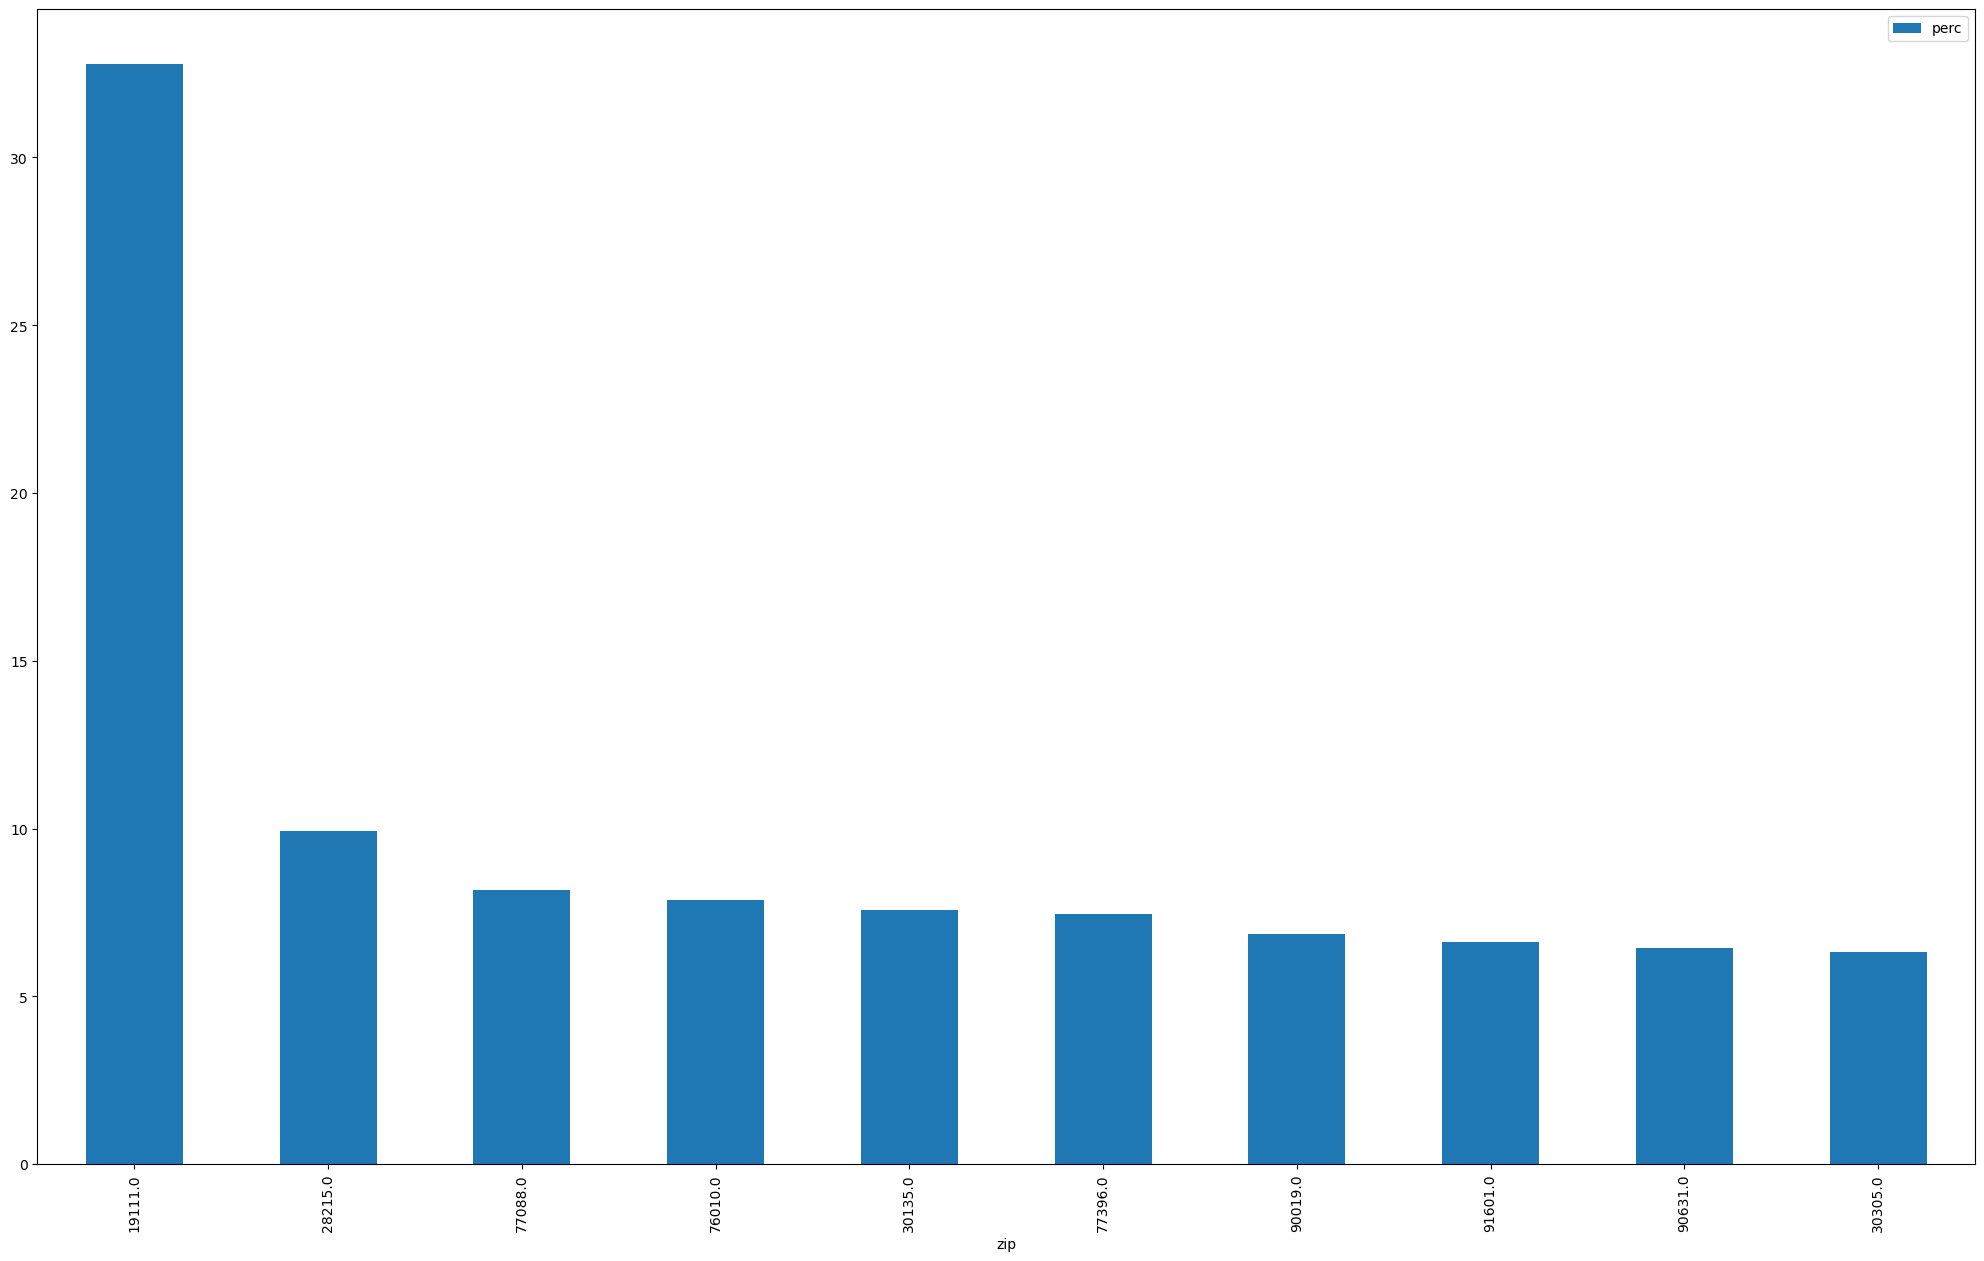

In [124]:
mm.plot(x = 'zip', y = 'perc', figsize = (25,15), kind = 'bar')


In [59]:
m = Xdata_val.groupby(["industry", "y_pred"]).size().groupby(level=0).mean().reset_index().rename(columns={0: '0-15secs predictions'})


KeyError: 'industry'

In [52]:
mm = m.sort_values(by = '0-15secs predictions', ascending = False)[:10]
mm['perc'] = (mm['0-15secs predictions'] /  mm['0-15secs predictions'].sum())*100
mm

,zip,0-15secs predictions,perc
189,19111.0,9395.5,21.358749
808,85326.0,6557.5,14.907136
246,28215.0,5071.5,11.529019
565,63033.0,4718.0,10.725409
872,90631.0,4136.0,9.402351
169,18018.0,3094.0,7.033577
198,19135.0,2986.5,6.789197
487,55076.0,2708.0,6.156084
384,33881.0,2706.0,6.151538
1015,95660.0,2616.0,5.946941


<AxesSubplot:xlabel='industry'>

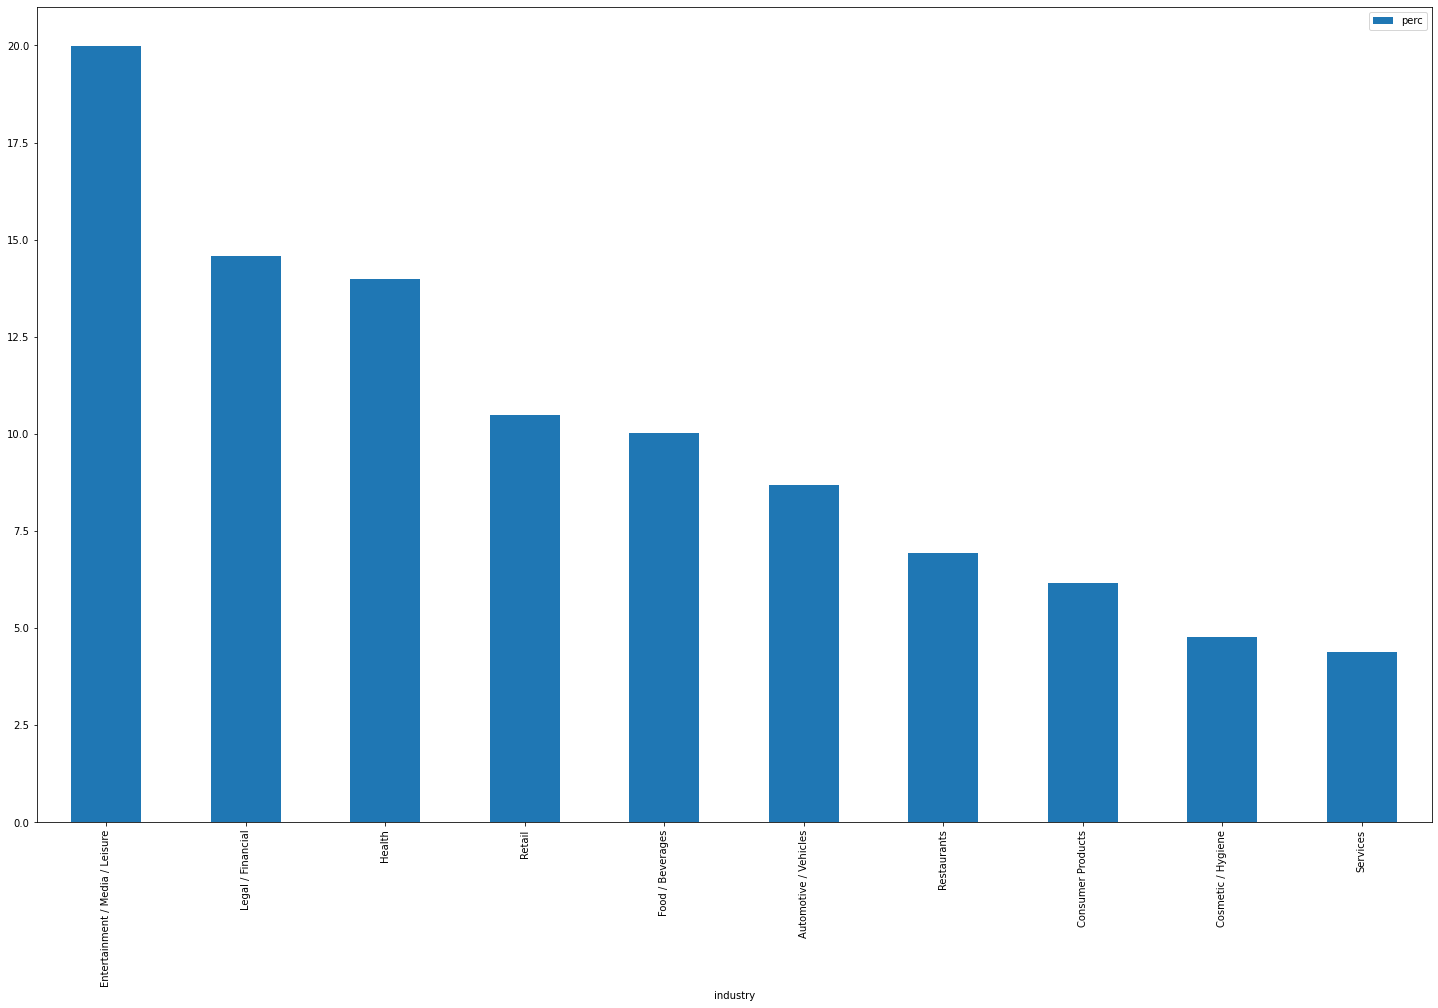

In [79]:
mm.plot(x = 'industry', y = 'perc', figsize = (25,15), kind = 'bar')


In [73]:
m = Xdata_val.groupby(["model", "y_pred"]).size().groupby(level=0).mean().reset_index().rename(columns={0: '0-15secs predictions'})


In [74]:
mm = m.sort_values(by = '0-15secs predictions', ascending = False)[:10]
mm['perc'] = (mm['0-15secs predictions'] /  mm['0-15secs predictions'].sum())*100
mm

,model,0-15secs predictions,perc
100,Roku Express,26105.5,33.344190
107,Roku Streaming Stick+,10433.5,13.326564
103,Roku Premiere,8842.5,11.294402
106,Roku Streaming Stick,6878.0,8.785173
19,32S331,6256.0,7.990701
108,Roku Ultra,6238.0,7.967710
30,49S405,4471.0,5.710746
62,65R6+,4109.0,5.248368
105,Roku Stick,2605.0,3.327330
36,50S421,2352.5,3.004815


<AxesSubplot:xlabel='model'>

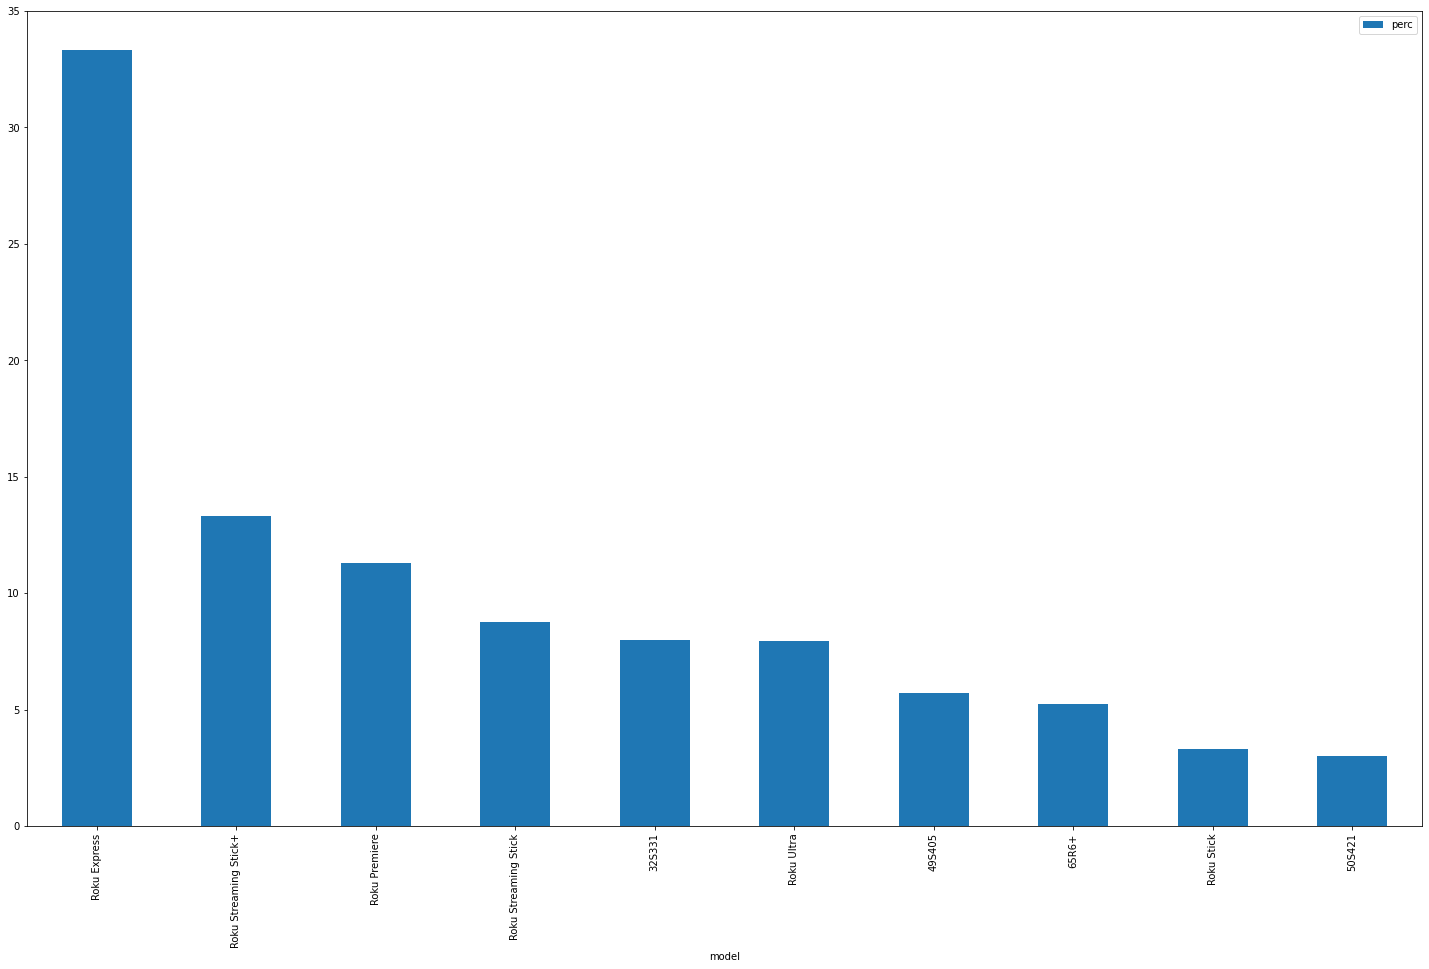

In [75]:
mm.plot(x = 'model', y = 'perc', figsize = (25,15), kind = 'bar')


In [88]:
m = Xdata_val.groupby(["zip", "y_pred"]).size().groupby(level=0).mean().reset_index().rename(columns={0: '0-15secs predictions'})
mm = m.sort_values(by = '0-15secs predictions', ascending = False)[:10]
mm['perc'] = (mm['0-15secs predictions'] /  mm['0-15secs predictions'].sum())*100
mm

,zip,0-15secs predictions,perc
66,19111,12241.0,27.295634
326,85326,6649.0,14.826294
346,90631,5790.0,12.910850
87,28215,5032.0,11.220622
160,33881,2805.0,6.254738
239,63033,2680.0,5.976007
206,55076,2672.0,5.958168
365,92869,2369.0,5.282522
119,30135,2367.0,5.278063
154,33136,2241.0,4.997101


<AxesSubplot:xlabel='zip'>

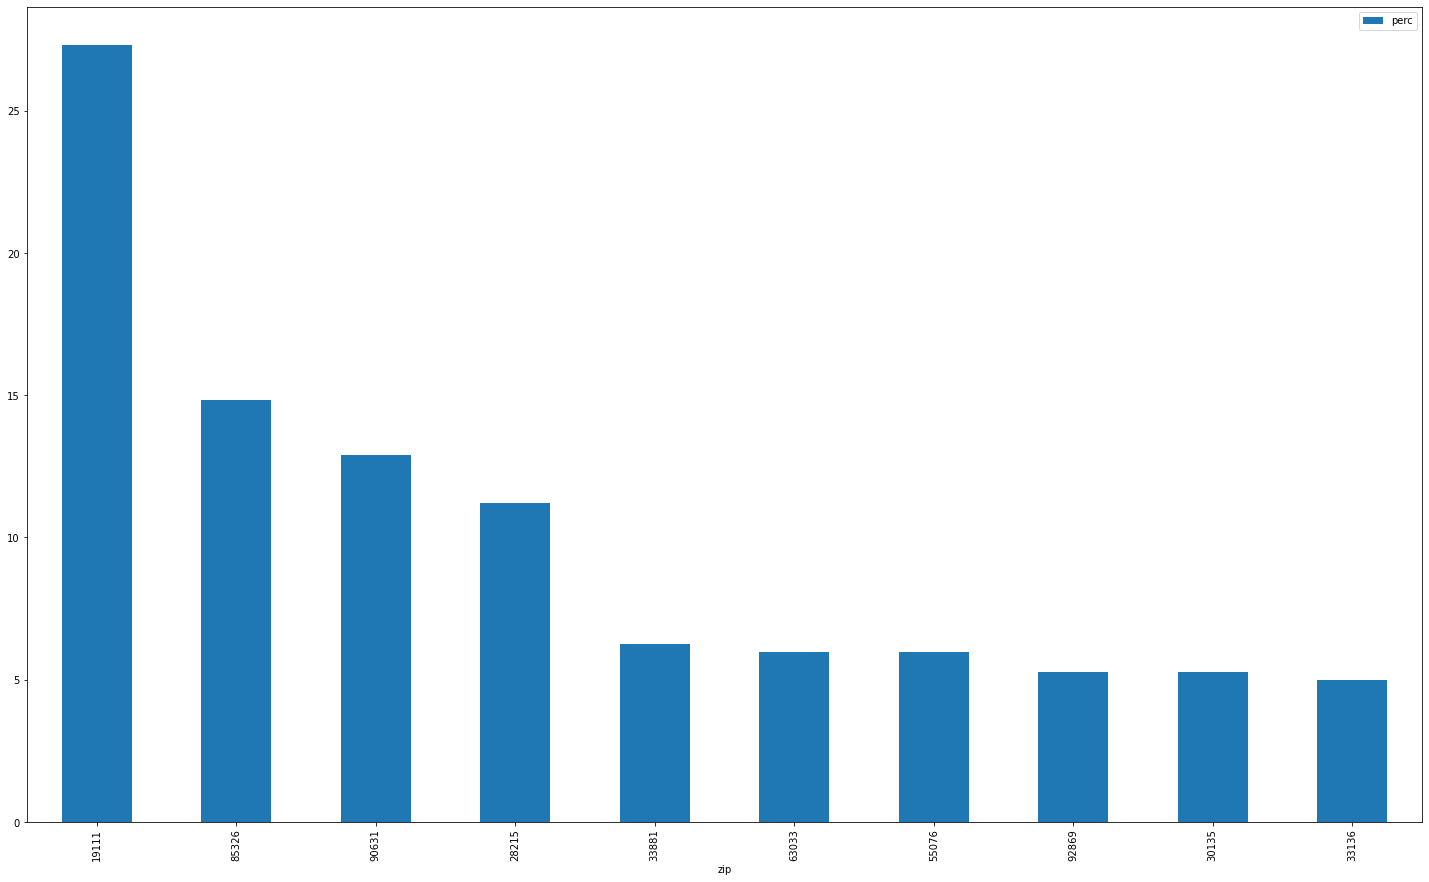

In [89]:
mm.plot(x = 'zip', y = 'perc', figsize = (25,15), kind = 'bar')


In [90]:
m = Xdata_val.groupby(["tvision_device_type", "y_pred"]).size().groupby(level=0).mean().reset_index().rename(columns={0: '0-15secs predictions'})
mm = m.sort_values(by = '0-15secs predictions', ascending = False)[:10]
mm['perc'] = (mm['0-15secs predictions'] /  mm['0-15secs predictions'].sum())*100
mm

,tvision_device_type,0-15secs predictions,perc
2,Streaming Device,69392.0,59.117900
1,Smart TV,47538.0,40.499578
0,Smart Device,449.0,0.382522


<AxesSubplot:xlabel='tvision_device_type'>

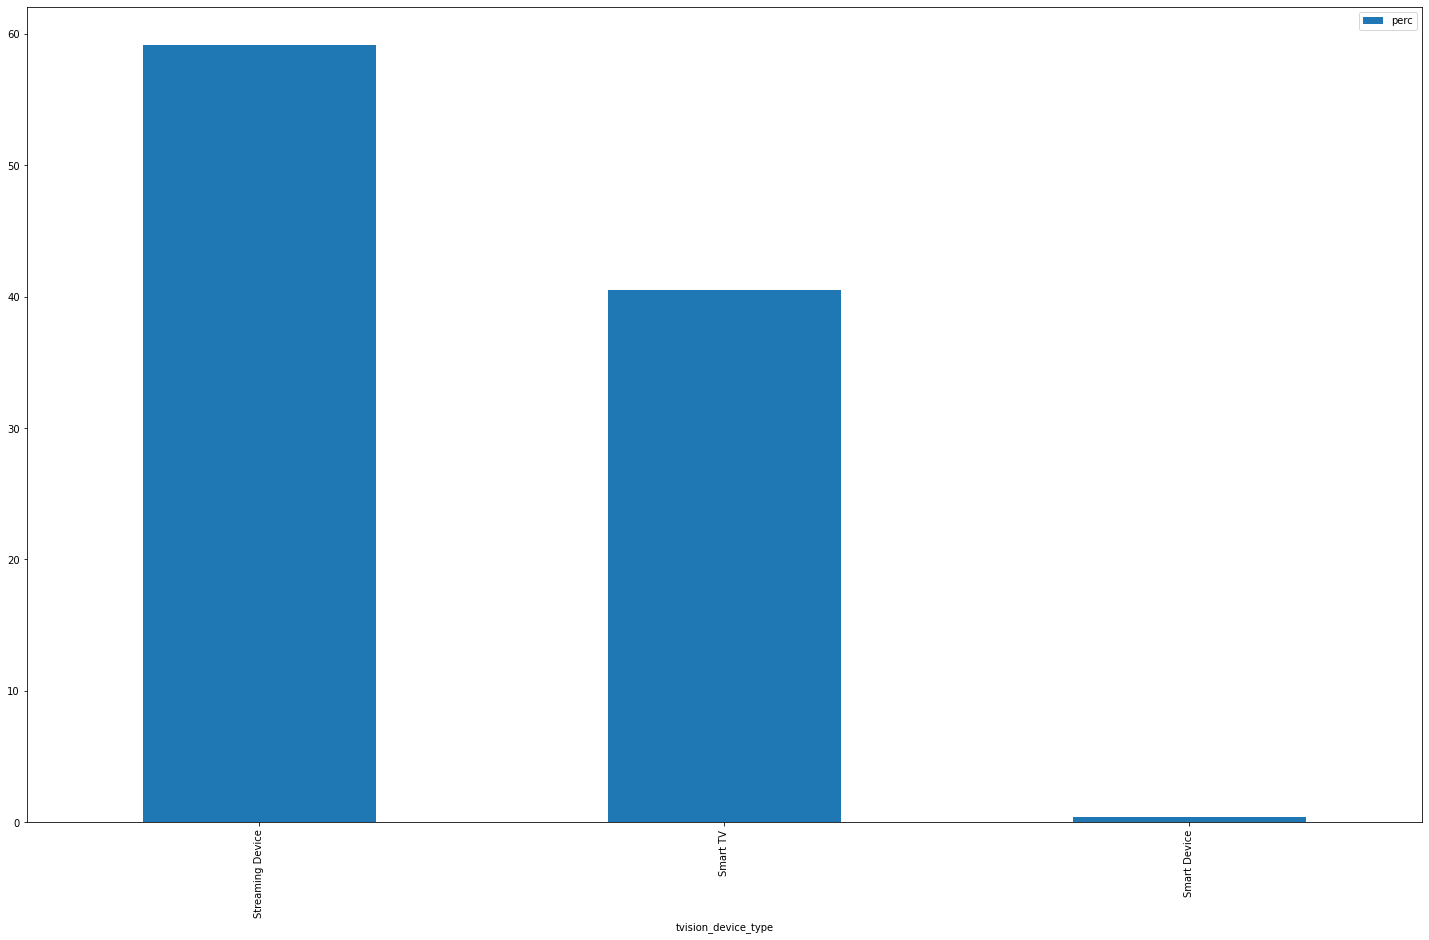

In [91]:
mm.plot(x = 'tvision_device_type', y = 'perc', figsize = (25,15), kind = 'bar')


In [ ]:
m = Xdata_val.groupby(["tvision_device_type", "y_pred"]).size().groupby(level=0).mean().reset_index().rename(columns={0: '0-15secs predictions'})
mm = m.sort_values(by = '0-15secs predictions', ascending = False)[:10]
mm['perc'] = (mm['0-15secs predictions'] /  mm['0-15secs predictions'].sum())*100

In [59]:
!pip install plot-metric


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


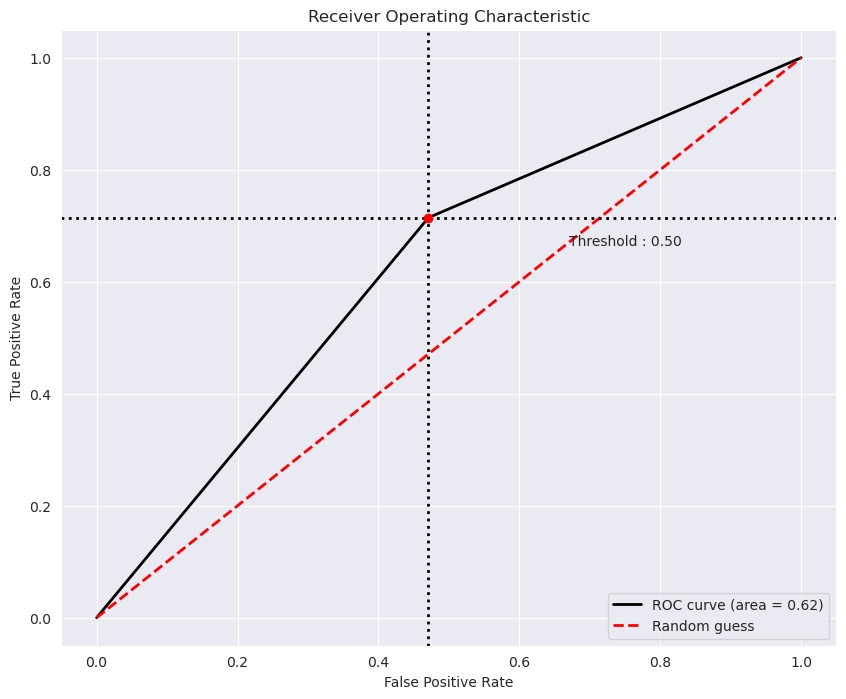

In [126]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(Ydata_val, preds_class, labels=["Class 0", "Class 1"], threshold=0.5)

# Figures
plt.figure(figsize=(10,8))
bc.plot_roc_curve()
plt.show()

In [125]:
import shap
# shap_values = model.get_feature_importance(Pool(Xdata_val, label=Ydata_val,cat_features=categorical_features_indices), 
#                                                                      type="ShapValues")
# expected_value = shap_values[0,-1]
# shap_values = shap_values[:,:-1]

# shap.initjs()
# shap.force_plot(expected_value, shap_values[3,:], Xdata_val.iloc[3,:])

# #shap.summary_plot(shap_values, Xdata_val)
# shap.summary_plot(shap_values, Xdata_val)

In [126]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xdata_train)

model.get_feature_importance(prettified=True)


,Feature Id,Importances
0,zip,42.798387
1,Geosegmentid,31.804615
2,model,23.071701
3,USERHOUROFWEEK,2.325297


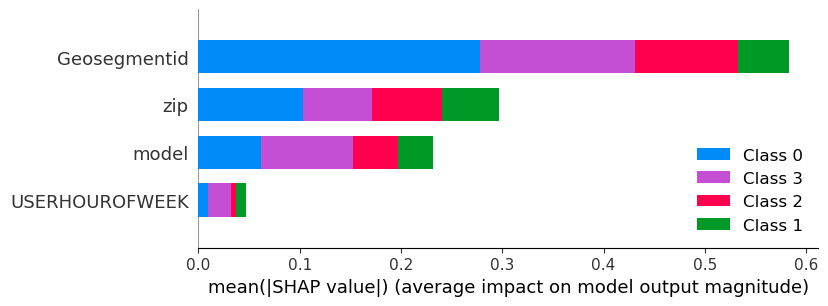

In [128]:
shap.initjs()
##Class 1 
shap.summary_plot(shap_values, Xdata_train.values, feature_names = Xdata_train.columns)



In [172]:

#### Define variables to be used from the trained catboost model
##Training set
train = Xdata_train
train['id_target'] = Ydata_train
train = train.sample(frac=0.05)

#Testing Set
mydf = Xdata_val
mydf['id_target'] = Ydata_val
#Specify the column names that you will use for the bidlist (These are just example names)
col_list = ['model', 'zip', "USERHOUROFWEEK" ,'Geosegmentid']



In [173]:
mydf = mydf.sample(frac=0.05)
mydf

,model,zip,USERHOUROFWEEK,Geosegmentid,y_pred,id_target
3517125,50S423,95630.0,49.0,bf2v46outy,0,0
286713,49S405,19111.0,66.0,v6xjyfu13i,0,0
1640378,Roku Express,28215.0,79.0,psa39ri6ia,0,2
2147961,LC-58Q73+,19320.0,140.0,jst5p3pvv8,0,1
876012,Roku Express,85326.0,21.0,3znti4q4v4,0,0
...,...,...,...,...,...,...
505862,49S405,19111.0,152.0,v6xjyfu13i,0,0
2904810,INSIGNIA NS-32DR310NA17,76137.0,69.0,pv62uox87r,0,0
613537,49S405,19111.0,44.0,v6xjyfu13i,0,0
2067908,Roku Streaming Stick+,30019.0,53.0,62m21jfdj7,0,2


In [174]:
### Define Bidlist Functions

import pandas as pd
from ttd_api_authenticate import *
from TradedeskCredentials import *
from bid_lists_generator import *

def apply_bid_lists_to_adgroups(token, bid_list_ids, adgroupids, enable_on_apply=True, 
                                on_error='continue', verbose=False):
    #on_error in ['continue', 'raise']
    fails = []
    results = []
    for i, adgroup in enumerate(adgroupids):
        if verbose:
            printstr = f"Adding {len(bid_list_ids)} to adgroup {adgroup}"
            print(printstr, end='\r')
            print(' '*len(printstr), end='\r')
        try:
            current_state = generic_get(f'adgroup/{adgroup}', token=token).json()
        except Exception as e:
            if on_error == 'continue':
                fails.append(adgroup)
                continue
            elif on_error == 'raise':
                raise ValueError(f"Error getting adgroup id '{adgroup}' (index {i})")
        
        current_bid_lists = current_state['AssociatedBidLists']
        current_bid_lists.extend([{'BidListId':x, 
                                'IsEnabled':enable_on_apply} for x in bid_list_ids])
        payload={'AdGroupId':adgroup, 'AssociatedBidLists':current_bid_lists}
        try:
            result = generic_put('adgroup', token=token, payload=payload).json()
            results.append({adgroup:result['AssociatedBidLists']})
        except Exception as e:
            if on_error == 'continue':
                fails.append(adgroup)
                continue
            elif on_error == 'raise':
                raise ValueError(f"Error updating adgroup id '{adgroup}' (index {i})")
        print('Uploaded Successfully')

In [175]:
def bid_col (mydf, col, target, num):
    df1 = mydf.loc[mydf[target] == 1, [col, target]]
    df2 = df1.groupby(col).agg(np.count_nonzero).sort_values(by = target, ascending=False)
    df3 = df2.iloc[0:num,]
    df3 = df3.reset_index()
    df3['key'] = 0
    return df3





In [176]:


def df_list_make(train, col_list, targeted_id):
    df_list = []
    for i in col_list:
        j = bid_col (train, col = i, target = targeted_id, num = 100000)
        df_list.append(j)
    return df_list
df_list = df_list_make(train, col_list, targeted_id = 'id_target')
def cross_join (df_list, col_list):
    lenth = len(df_list)-1
    i = 0
    mydf = df_list[i]
    while i < lenth:
        mydf = pd.merge(mydf, df_list[i+1], on= 'key')
        i = i+1
    mydf = mydf[col_list]
    return mydf


In [177]:
def cross_join(df_list, col_list):
    lenth = len(df_list)-1
    i = 0
    mydf = df_list[i]
    while i < lenth:
        mydf = pd.merge(mydf, df_list[i+1], on= 'key')
        i = i+1
    mydf = mydf[col_list]
    return mydf

In [178]:

#Call the bidlist functions
df_list = df_list_make(train, col_list, targeted_id = 'id_target')

#Use your trained catboost model. If it isn't called clf, change the name here.


In [179]:
df_cross = cross_join(df_list, col_list)


Passing 'suffixes' which cause duplicate columns {'id_target_x'} in the result is deprecated and will raise a MergeError in a future version.


In [180]:
df_cross = df_cross.sample(frac=0.01)
df_cross

,model,zip,USERHOUROFWEEK,Geosegmentid
631192104,Insignia NS-55DR710NA17,85326.0,144.0,r44ea7eptm
23305772,Roku Streaming Stick+,90018.0,35.0,uoafktqzqp
5003429,Roku Express,10028.0,34.0,ejqvcmga8i
77819802,Roku Streaming Stick,30096.0,62.0,62m21jfdj7
553829597,LC-55LBU591U,30305.0,120.0,ljt9vy6s1v
...,...,...,...,...
21526469,Roku Streaming Stick+,90631.0,138.0,y5eqqbm7j4
539278540,WR43FX2019,85298.0,48.0,7ok9ewnf8l
156531502,55S515,46237.0,37.0,4jsd435rp6
628363459,INSIGNIA NS-24ER310NA17,46901.0,80.0,tc8nejnwpu


In [181]:


categorical_features_indices = [df_cross.columns.get_loc(col) for col in categorical_features]
categorical_features_indices

[0, 1, 3, 2]

In [182]:
probs = model.predict_proba(df_cross)
probs

array([[0.86512613, 0.07917756, 0.052366  , 0.00333031],
       [0.69507779, 0.15007911, 0.14211652, 0.01272658],
       [0.76675726, 0.11514883, 0.10534079, 0.01275313],
       ...,
       [0.78526619, 0.09199132, 0.11393576, 0.00880674],
       [0.76761061, 0.11659739, 0.10867131, 0.00712069],
       [0.77166924, 0.12196829, 0.10031816, 0.00604431]])

In [189]:
df_prob = pd.DataFrame({'Class1': probs[:, 0], 'Class2': probs[:, 1], 'Class3': probs[:, 2], 'Class4': probs[:, 3]})
df_prob

,Class1,Class2,Class3,Class4
0,0.865126,0.079178,0.052366,0.003330
1,0.695078,0.150079,0.142117,0.012727
2,0.766757,0.115149,0.105341,0.012753
3,0.590173,0.186415,0.201908,0.021504
4,0.637606,0.173027,0.178368,0.010999
...,...,...,...,...
6377974,0.805421,0.099281,0.085808,0.009490
6377975,0.818983,0.095427,0.079138,0.006452
6377976,0.785266,0.091991,0.113936,0.008807
6377977,0.767611,0.116597,0.108671,0.007121


In [190]:
bid_model = df_cross

#reset index of each DataFrame
df_prob.reset_index(drop=True, inplace=True)
bid_model.reset_index(drop=True, inplace=True)

#column-bind two DataFrames
df3 = pd.concat([bid_model, df_prob], axis=1)
bid_model = df3
bid_model

,model,zip,USERHOUROFWEEK,Geosegmentid,Class1,Class2,Class3,Class4
0,Insignia NS-55DR710NA17,85326.0,144.0,r44ea7eptm,0.865126,0.079178,0.052366,0.003330
1,Roku Streaming Stick+,90018.0,35.0,uoafktqzqp,0.695078,0.150079,0.142117,0.012727
2,Roku Express,10028.0,34.0,ejqvcmga8i,0.766757,0.115149,0.105341,0.012753
3,Roku Streaming Stick,30096.0,62.0,62m21jfdj7,0.590173,0.186415,0.201908,0.021504
4,LC-55LBU591U,30305.0,120.0,ljt9vy6s1v,0.637606,0.173027,0.178368,0.010999
...,...,...,...,...,...,...,...,...
6377974,Roku Streaming Stick+,90631.0,138.0,y5eqqbm7j4,0.805421,0.099281,0.085808,0.009490
6377975,WR43FX2019,85298.0,48.0,7ok9ewnf8l,0.818983,0.095427,0.079138,0.006452
6377976,55S515,46237.0,37.0,4jsd435rp6,0.785266,0.091991,0.113936,0.008807
6377977,INSIGNIA NS-24ER310NA17,46901.0,80.0,tc8nejnwpu,0.767611,0.116597,0.108671,0.007121


In [185]:
bid_model['zip'] =bid_model['zip'].round(0)

bid_model['zip'] = bid_model['zip'].astype(int)
bid_model

,model,zip,USERHOUROFWEEK,Geosegmentid,Negative,Positive
0,Insignia NS-55DR710NA17,85326,144.0,r44ea7eptm,0.865126,0.079178
1,Roku Streaming Stick+,90018,35.0,uoafktqzqp,0.695078,0.150079
2,Roku Express,10028,34.0,ejqvcmga8i,0.766757,0.115149
3,Roku Streaming Stick,30096,62.0,62m21jfdj7,0.590173,0.186415
4,LC-55LBU591U,30305,120.0,ljt9vy6s1v,0.637606,0.173027
...,...,...,...,...,...,...
6377974,Roku Streaming Stick+,90631,138.0,y5eqqbm7j4,0.805421,0.099281
6377975,WR43FX2019,85298,48.0,7ok9ewnf8l,0.818983,0.095427
6377976,55S515,46237,37.0,4jsd435rp6,0.785266,0.091991
6377977,INSIGNIA NS-24ER310NA17,46901,80.0,tc8nejnwpu,0.767611,0.116597


In [191]:
bid_model.to_csv('bid_model_multiclass.csv')


In [200]:
m = bid_model.groupby(["zip", "Class1"]).size()
m

zip      Class1  
1602.0   0.176813    1
         0.183211    1
         0.190878    1
         0.191337    1
         0.193007    1
                    ..
98513.0  0.968087    1
         0.968657    1
         0.968671    1
         0.968783    1
         0.968802    1
Length: 3712502, dtype: int64

In [194]:

bid_model_zip = bid_model[bid_model["zip"] == 95662]


In [195]:
bid_model_zip

,model,zip,USERHOUROFWEEK,Geosegmentid,Class1,Class2,Class3,Class4
222,Roku 4,95662.0,64.0,zs6skfi3vn,0.785917,0.122256,0.087125,0.004702
601,TCL 49S305,95662.0,86.0,iw96nsj2j3,0.783715,0.096157,0.112865,0.007263
745,32S335,95662.0,9.0,xovbdw9ee9,0.716820,0.196093,0.080601,0.006487
853,50S425,95662.0,147.0,wotaadtgf3,0.638363,0.165855,0.183124,0.012658
1378,55S515,95662.0,1.0,mnrk8522be,0.571773,0.185593,0.231662,0.010972
...,...,...,...,...,...,...,...,...
6377147,55S425,95662.0,47.0,amkq7qc69p,0.740552,0.147841,0.105352,0.006254
6377189,100005842,95662.0,145.0,eyfp3iclat,0.654464,0.150160,0.181438,0.013938
6377214,WR58UX4019,95662.0,41.0,1cv2jvvsgr,0.596709,0.170856,0.214210,0.018226
6377216,32S335,95662.0,67.0,5zelnbn5uf,0.870035,0.084274,0.043648,0.002042


Text(0.5, 0, 'CLV')

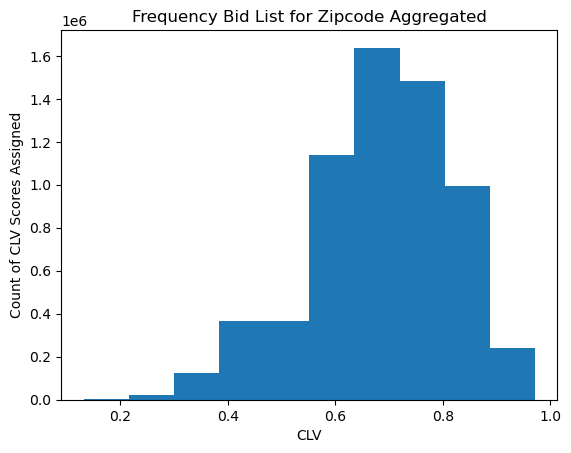

In [196]:
#bid_model['Positive'].value_counts(normalize=True).plot(figsize=(12,12), kind='kde')
bid_model['Class1'].plot(kind = 'hist')
plt.title('Frequency Bid List for Zipcode Aggregated')
plt.ylabel('Count of CLV Scores Assigned')
plt.xlabel('CLV')

Text(0.5, 0, 'CLV')

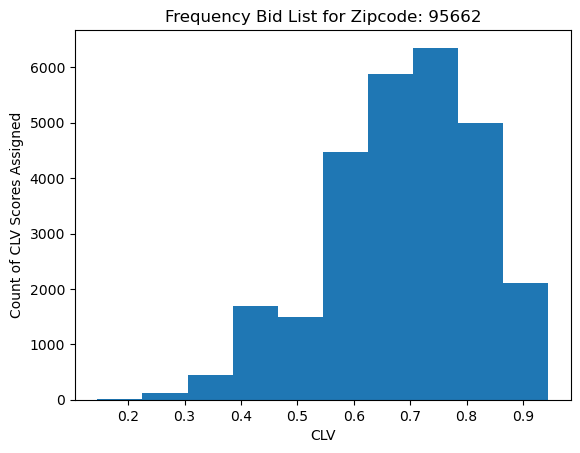

In [197]:
from scipy.stats import norm  

bid_model_zip['Class1'].plot(kind = 'hist')
plt.title('Frequency Bid List for Zipcode: 95662')
plt.ylabel('Count of CLV Scores Assigned')
plt.xlabel('CLV')